In [ ]:
import numpy as np
import cv2
from detectfaces import get_faces
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras import backend as K
import matplotlib.pyplot as plt
import time

Known_distance = 46.2
 
# width of face in the real world or Object Plane
# centimeter

Known_width = 14.3
 
# Colors

# GREEN = (0, 255, 0)

# RED = (0, 0, 255)

# WHITE = (255, 255, 255)

# BLACK = (0, 0, 0)
 
# defining the fonts

fonts = cv2.FONT_HERSHEY_COMPLEX
 
# face detector object

face_detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
 
# focal length finder function

def Focal_Length_Finder(measured_distance, real_width, width_in_rf_image):
 

    # finding the focal length

    focal_length = (width_in_rf_image * measured_distance) / real_width

    return focal_length
 
# distance estimation function

def Distance_finder(Focal_Length, real_face_width, face_width_in_frame):
 

    distance = ( real_face_width* Focal_Length)/face_width_in_frame
 

    # return the distance

    return distance

def face_data(image):
 

    face_width = 0  # making face width to zero
 

    # converting color image ot gray scale image

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 

    # detecting face in the image

    faces = face_detector.detectMultiScale(gray_image, 1.3, 5)
 

    # looping through the faces detect in the image

    # getting coordinates x, y , width and height

    for (x, y, h, w) in faces:
 

        # draw the rectangle on the face

        #cv2.rectangle(image, (x, y), (x+w, y+h), GREEN, 2)
 

        # getting face width in the pixels

        face_width = w
 

    # return the face width in pixel

    return face_width
 
 
# reading reference_image from directory

ref_image = cv2.imread("Ref_image.png")
 
# find the face width(pixels) in the reference_image

ref_image_face_width = face_data(ref_image)
print(ref_image_face_width)
# get the focal by calling "Focal_Length_Finder"
# face width in reference(pixels),
# Known_distance(centimeters),
# known_width(centimeters)

Focal_length_found = Focal_Length_Finder(Known_distance, Known_width, ref_image_face_width)
 
print(Focal_length_found)

img_rows, img_cols = 48, 48
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion = ['Angry', "Disgust", 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#emotion = ['Bored', "Bored", 'Confusion', 'Satisfaction', 'Confusion', 'Confusion', 'Satisfaction']
#emotion = ['Bored', "Bored", 'Confusion', 'Satisfaction', 'Confusion', 'Confusion', 'Confusion']
# emotion3 = ['Angry', "Disgust", 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
font = cv2.FONT_HERSHEY_SIMPLEX

model = []
print('Loading Models...')
print('0/3')
for i in range(2):
    m = load_model('C:/Users/TOTAN/Downloads/EmotionRecognition-master/EmotionRecognition-master/saved_model_main/' + 'cnn'+str(i)+'.h5')
    print(str(i+1) + '/3')
    model.append(m)

m = load_model('C:/Users/TOTAN/Downloads/EmotionRecognition-master/EmotionRecognition-master/saved_model_main/ensemble.h5')
model.append(m)
print('3/3')

print("Loading Complete!")

def predict(x):
    x_rev = np.flip(x, 1)
    x = x.astype('float32')
    x_rev = x_rev.astype('float32')
    x /= 255
    x_rev /= 255
    p = np.zeros((1, 14))
    p[:,0:7] = model[0].predict(x.reshape(1,48,48,1))
    p[:,7:14] = model[1].predict(x_rev.reshape(1,48,48,1))
    pre = model[2].predict(p)
    return pre

def faceBox(faceNet,frame):
    frameHeight=frame.shape[0]
    frameWidth=frame.shape[1]
    blob=cv2.dnn.blobFromImage(frame, 1.0, (300,300), [104,117,123], swapRB=False)
    faceNet.setInput(blob)
    detection=faceNet.forward()
    bboxs=[]
    for i in range(detection.shape[2]):
        confidence=detection[0,0,i,2]
        if confidence>0.7:
            x1=int(detection[0,0,i,3]*frameWidth)
            y1=int(detection[0,0,i,4]*frameHeight)
            x2=int(detection[0,0,i,5]*frameWidth)
            y2=int(detection[0,0,i,6]*frameHeight)
            bboxs.append([x1,y1,x2,y2])
            cv2.rectangle(frame, (x1,y1),(x2,y2),(0,255,0), 1)
    return frame, bboxs

faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"

ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

faceNet=cv2.dnn.readNet(faceModel, faceProto)
ageNet=cv2.dnn.readNet(ageModel,ageProto)
genderNet=cv2.dnn.readNet(genderModel,genderProto)

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)','(25-32)',  '(38-43)','(48-53)', '(60-100)']
genderList = ['Male', 'Female']

test_list = []
c = 0
cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     cap.open()
padding=20

while(True):
    ret, img = cap.read()
    
    #time.sleep(2)
    _, frame = cap.read()

    face_width_in_frame = face_data(frame)

    if face_width_in_frame != 0:

        Distance = Distance_finder(Focal_length_found, Known_width, face_width_in_frame)
        if Distance < 50 :
            print("Engaged")
        else:
            print("Not Engaged")
 
        cv2.putText(img, f"Distance: {round(Distance,2)} CM", (30, 35), fonts, 0.6, (0,255,0), 2)

    faces = get_faces(img, method='dnn')
    for i, (y,x,face) in enumerate(faces):
        pre = predict(face)
        k = np.argmax(pre)
        time.sleep(0.5)
        c = c + 1
        txt = emotion[k]  #+ ' [' + str(int(pre[0,k]*100)) + '%]'
        print(txt)
        print(c)
        test_list.append(txt)
        #print ("Original list : " + str(test_list))
        max = 0
        res = test_list[0]
        for i in test_list:
            freq = test_list.count(i)
            if freq > max:
                max = freq
                res = i

        # printing result
        # print ("Most frequent number is : " + str(res))
        if(c == 20):
            cv2.putText(img, res, (x, y), font, 0.5,(0,255,0),1,cv2.LINE_AA)
            print ("Most frequent number is : " + str(res))
            c = 0
            test_list.clear()
        #cv2.putText(img, txt, (x, y), font, 0.5,(0,255,0),1,cv2.LINE_AA)
        # cv2.imshow(str(i), face)
        

#     frame,bboxs=faceBox(faceNet,img)
#     for bbox in bboxs:
#         face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]
#         blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
#         genderNet.setInput(blob)
#         genderPred=genderNet.forward()
#         gender=genderList[genderPred[0].argmax()]

#         ageNet.setInput(blob)
#         agePred=ageNet.forward()
#         age=ageList[agePred[0].argmax()]

#         label="{},{},{}".format(age,gender,txt)
        #cv2.rectangle(frame,(bbox[0], bbox[1]-30), (bbox[2], bbox[1]), (0,255,0),-1) 
        #cv2.putText(frame, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1,cv2.LINE_AA)

    cv2.imshow('Camera', img)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

182
588.0
Loading Models...
0/3
1/3
2/3
3/3
Loading Complete!
Engaged
Neutral
1
Engaged
Neutral
2
Not Engaged
Neutral
3
Engaged
Neutral
4
Fear
5
Not Engaged
Neutral
6
Not Engaged
Neutral
7
Fear
8
Not Engaged
Neutral
9
Neutral
10
Engaged
Neutral
11
Fear
12
Not Engaged
Neutral
13
Fear
14
Not Engaged
Neutral
15
Neutral
16
Neutral
17
Neutral
18
Engaged
Angry
19
Neutral
20
Most frequent number is : Neutral
Not Engaged
Neutral
1
Fear
2
Engaged
Neutral
3
Neutral
4
Engaged
Neutral
5
Not Engaged
Neutral
6
Not Engaged
Neutral
7
Not Engaged
Neutral
8
Not Engaged
Neutral
9
Neutral
10
Neutral
11
Neutral
12
Fear
13
Neutral
14
Neutral
15
Neutral
16
Neutral
17
Neutral
18
Neutral
19
Neutral
20
Most frequent number is : Neutral
Neutral
1
Neutral
2
Engaged
Neutral
3
Engaged
Neutral
4
Not Engaged
Neutral
5
Engaged
Neutral
6
Engaged
Neutral
7
Engaged
Neutral
8
Engaged
Neutral
9
Engaged
Neutral
10
Not Engaged
Neutral
11
Engaged
Neutral
12
Neutral
13
Engaged
Neutral
14
Engaged
Neutral
15
Engaged
Neutral
16
N

Loading Models...
0/3
1/3
2/3
3/3
Loading Complete!
[[ 229    0  262]
 [ 104    0 1489]
 [  48    0 1457]]


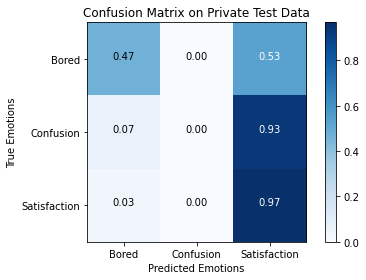

In [3]:
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.models import load_model
import matplotlib.pyplot as plt
from keras import backend as K
import pandas as pd
import numpy as np
import itertools
import keras
import cv2

#emotion = ['Angry', "Disgust", 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#emotion = ['Bored', "Bored", 'Confusion', 'Satisfaction', 'Confusion', 'Confusion', 'Satisfaction']
emotion = ['Bored', 'Confusion', 'Satisfaction']
img_rows, img_cols = 48, 48
num_classes = 3

data = pd.read_csv('data/fer2013.csv', delimiter=',')
data_test = data[32298:]
y_test = data_test['emotion'].values

x_test = np.zeros((y_test.shape[0], 48*48))
for i in range(y_test.shape[0]):
    x_test[i] = np.fromstring(data_test['pixels'][32298+i], dtype=int, sep=' ')

x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_rev = np.flip(x_test, 2)

input_shape = (img_rows, img_cols, 1)
x_test = x_test.astype('float32')
x_test_rev = x_test_rev.astype('float32')
x_test /= 255
x_test_rev /= 255
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

print('Loading Models...')
print('0/3')
model = []
for i in range(2):
    m = load_model('saved_model/' + 'cnn'+str(i)+'.h5')
    print(str(i+1) + '/3')
    model.append(m)

m = load_model('saved_model/ensemble.h5')
model.append(m)
print('3/3')
print("Loading Complete!")

def plot_confusion_matrix(cm):
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix on Private Test Data')
    plt.colorbar()
    tick_marks = np.arange(len(emotion))
    plt.xticks(tick_marks, emotion)
    plt.yticks(tick_marks, emotion)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Emotions')
    plt.xlabel('Predicted Emotions')
    plt.tight_layout()

p = np.zeros((y_test.shape[0],6))
p[:,0:3] = model[0].predict(x_test)
p[:,3:6] = model[1].predict(x_test_rev)
y_pred = model[2].predict(p)
yp = np.argmax(y_pred, axis=1)
yt = np.argmax(y_test, axis=1)
cm = confusion_matrix(yt, yp)
plot_confusion_matrix(cm)
plt.savefig("cm.png")
plt.show()
